In [39]:
import json
import re
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections.abc import Mapping, Sequence

# Variáveis

In [40]:
DIR_PATTERN = re.compile(
    r"^fedavg_random_(?P<strategy>constant|aff|hetaaff|criticalfl|dynff)_battery_False_"
    r"dataset_cifar10_dir_(?P<alpha>0\.1|1\.0)_seed_(?P<seed>1|2|3|4|5)$"
)

MILLIJOULES_PER_J = 1000.0
BYTES_PER_MB = 1e6  # use 1024**2 para MiB
PARTICIPANTS_ORDER = [10]
ALPHA_ORDER = [0.1, 1.0]
ROOT_CONSTANT = Path("/home/filipe/Workspace/dynff/results/new/exp-1/shufflenet/constant").expanduser().resolve()
ROOT_CRITICAL = Path("/home/filipe/Workspace/dynff/results/new/exp-1/shufflenet/critical").expanduser().resolve()
ROOT_AFF = Path("/home/filipe/Workspace/dynff/results/new/exp-1/shufflenet/aff").expanduser().resolve()
# ROOT_HETAAFF = Path("/home/filipe/Workspace/dynff/results/new/slower_clients/exp-1/shufflenet/hetaaff").expanduser().resolve()
ROOT_DYNFF_DYN = Path("/home/filipe/Workspace/dynff/results/new/exp-1/shufflenet/dynff/ack-3").expanduser().resolve()
ROOT_DYNFF_FIX = Path("/home/filipe/Workspace/dynff/results/new/exp-1/shufflenet/dynff/fixed").expanduser().resolve()

OUTPUT = Path("/home/filipe/Workspace/dynff/experiments/motivational/figs").expanduser().resolve()
OUTPUT.mkdir(parents=True, exist_ok=True)

# Função Auxiliar

In [41]:
def read_json(path: Path):
    try:
        with path.open("r", encoding="utf-8") as f:
            return json.load(f)
    except Exception as e:
        print(f"[WARN] Falha ao ler {path}: {e}")
        return None


def parse_round_key_to_idx(k: str) -> int:
    # chaves deslocadas em +1: "1" -> rodada 0
    try:
        return int(k) - 1
    except Exception:
        return None


def stacked_differences(totals_by_participants):
    """
    Recebe dict {participants -> total}, retorna lista de segmentos empilhados
    correspondentes às diferenças cumulativas (crescentes com PARTICIPANTS_ORDER).
    Ex.: [total_5, total_10-total_5, total_20-total_10]
    """
    segs = []
    prev = 0.0
    for p in PARTICIPANTS_ORDER:
        cur = totals_by_participants.get(p, 0.0)
        segs.append(max(cur - prev, 0.0))
        prev = cur
    return segs


# ---------- Pipeline ----------
def collect_runs(root: Path, strategy: str = None):
    """
    Varre o root e retorna lista de runs com campos:
    (participants:int, alpha:float, seed:int, model_perf:dict, system_perf:dict)
    """
    runs = []
    for child in root.iterdir():
        if not child.is_dir():
            continue
        
        m = DIR_PATTERN.match(child.name)
        
        if not m:
            print(f"[WARN] Falha ao ler {child}: {m}")
            continue
        
        if strategy == None:
            strategy = str(m.group("strategy"))
        alpha = float(m.group("alpha"))
        seed = int(m.group("seed"))
        
        mp = read_json(child / "model_performance.json")
        sp = read_json(child / "system_performance.json")
        
        if mp is None or sp is None:
            print(f"[WARN] Ignorando {child} por falta de arquivos válidos.")
            continue

        runs.append((strategy, alpha, seed, mp, sp))
    
    return runs


def aggregate_accuracy_by_round(runs):
    """
    Retorna DataFrame com média por rodada de cen_accuracy para cada (participants, alpha).
    index: round, columns: MultiIndex (metric: 'cen_accuracy', participants, alpha)
    Também retorna um DF "long" com colunas: round, participants, alpha, cen_accuracy
    """
    acc_records = []
    for strategy, alpha, seed, mp, _ in runs:
        for rk, vals in mp.items():
            ridx = parse_round_key_to_idx(rk)
            if ridx is None or ridx < 0:
                continue
            acc = vals.get("cen_accuracy", None)
            if acc is None:
                continue
            acc_records.append({
                "round": ridx,
                "strategy": strategy,
                "alpha": alpha,
                "seed": seed,
                "cen_accuracy": acc
            })

    df = pd.DataFrame(acc_records)
    if df.empty:
        return pd.DataFrame(), pd.DataFrame()

    # média por rodada entre seeds
    df_mean = (
        df.groupby(["round", "strategy", "alpha"])["cen_accuracy"]
        .mean()
        .reset_index()
    )

    # Pivot para facilitar plot grade (linhas=participants, colunas=alpha)
    # Mantemos DF "long" para flexibilidade
    return df_mean, df  # (médias por rodada), (cru)


def aggregate_system_totals(runs):
    """
    Para cada (participants, alpha), soma por rodada e faz média entre seeds do:
      - total_mJ -> converte para Joules
      - num_transmited_bytes -> converte para MB
    Retorna dois dicts: totals_energy[alpha][participants] = total_J
                        totals_bytes[alpha][participants] = total_MB
    E também dataframes detalhados por run.
    """
    energy_records = []  # por run
    bytes_records = []

    for strategy, alpha, seed, _, sp in runs:
        # somar todas as rodadas do system_performance
        total_mJ = 0.0
        selected_mJ = 0.0
        total_bytes = 0.0
        for rk, vals in sp.items():
            ridx = parse_round_key_to_idx(rk)
            if ridx is None or ridx < 0:
                continue
            total_mJ += float(vals.get("total_mJ", 0.0))
            selected_mJ += float(vals.get("selected_mJ", 0.0))
            total_bytes += float(vals.get("num_transmited_bytes", 0.0))

        energy_records.append({
            "strategy": strategy,
            "alpha": alpha,
            "seed": seed,
            "total_J": total_mJ / MILLIJOULES_PER_J,
            "selected_J": selected_mJ / MILLIJOULES_PER_J 
        })
        bytes_records.append({
            "strategy": strategy,
            "alpha": alpha,
            "seed": seed,
            "total_MB": total_bytes / BYTES_PER_MB
        })

    dfe = pd.DataFrame(energy_records)
    dfb = pd.DataFrame(bytes_records)

    # média entre seeds
    dfe_total_mean = (
        dfe.groupby(["alpha", "strategy"])["total_J"]
        .mean()
        .reset_index()
    )
    dfe_selected_mean = (
        dfe.groupby(["alpha", "strategy"])["selected_J"]
        .mean()
        .reset_index()
    )
    dfb_mean = (
        dfb.groupby(["alpha", "strategy"])["total_MB"]
        .mean()
        .reset_index()
    )

    # construir dicts por alpha
    totals_energy = defaultdict(dict)
    selected_energy = defaultdict(dict)
    totals_bytes = defaultdict(dict)
    for _, row in dfe_total_mean.iterrows():
        totals_energy[row["alpha"]][row["strategy"]] = float(row["total_J"])
    for _, row in dfe_selected_mean.iterrows():
        selected_energy[row["alpha"]][row["strategy"]] = float(row["selected_J"])
    for _, row in dfb_mean.iterrows():
        totals_bytes[row["alpha"]][row["strategy"]] = float(row["total_MB"])

    return totals_energy, selected_energy, totals_bytes, dfe, dfb, dfe_total_mean, dfe_selected_mean, dfb_mean

def _flatten_strategy_dict(d):
    """Converte {alpha: {'estrategia': valor_mJ}} -> {alpha: valor_mJ}."""
    flat = {}
    for alpha, v in d.items():
        if isinstance(v, dict) and v:
            flat[float(alpha)] = float(next(iter(v.values())))
        else:
            flat[float(alpha)] = float(v)
    return flat

def plot_energy_grouped_with_labels(strategy_dicts, x_order=(0.1, 0.3, 1.0),
                                    title='Total Energy by Strategy vs. α'):
    """
    strategy_dicts: dict
        {
          'aff':        {0.1: {'aff': mJ}, 0.3: {'aff': mJ}, 1.0: {'aff': mJ}},
          'constant':   {0.1: {'constant': mJ}, ...},
          'criticalfl': {...},
          'hetaaff':    {...},
        }
    """
    # Achatar e garantir floats
    flat = {name: _flatten_strategy_dict(d) for name, d in strategy_dicts.items()}

    xs = list(x_order)
    n = len(xs)
    strategies = list(flat.keys())
    k = len(strategies)
    idx = np.arange(n)
    width = 0.8 / max(k, 1)

    # Pré-calcula todos os valores em MJ (J -> MJ divide por 1e6)
    vals_by_strategy = {
        name: [flat[name].get(x, np.nan) / 1e6 for x in xs] for name in strategies
    }
    # Máximo para dar folga vertical aos rótulos
    all_vals = np.array([v for vals in vals_by_strategy.values() for v in vals], dtype=float)
    ymax = np.nanmax(all_vals) if np.isfinite(np.nanmax(all_vals)) else 1.0

    fig, ax = plt.subplots(figsize=(9, 5))

    for i, name in enumerate(strategies):
        vals_mj = vals_by_strategy[name]
        # barras do grupo "name"
        bars = ax.bar(idx + (i - (k - 1)/2) * width, vals_mj, width, label=name)

        # rótulos (vazios para NaN)
        labels = [f"{v:.2f} MJ" if np.isfinite(v) else "" for v in vals_mj]

        # Usa bar_label se disponível (Matplotlib >= 3.4), senão fallback com text()
        if hasattr(ax, "bar_label"):
            ax.bar_label(bars, labels=labels, padding=3, fontsize=9)  # padding em pontos
        else:
            for rect, lab in zip(bars, labels):
                if not lab:
                    continue
                h = rect.get_height()
                ax.text(rect.get_x() + rect.get_width()/2, h, lab,
                        ha="center", va="bottom", fontsize=9)

    ax.set_xticks(idx)
    ax.set_xticklabels([str(x) for x in xs])
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel('Energy (MJ)')
    ax.set_title(title)
    ax.legend(title='Strategy')
    ax.grid(axis='y', linestyle=':', alpha=0.5)

    # Folga vertical para caber os rótulos
    ax.set_ylim(0, ymax * 1.12)

    fig.tight_layout()
    plt.show()

# ---------- Utils ----------
def _normalize_strategy_label(s: str) -> str:
    if not isinstance(s, str):
        return s
    m = {
        "constant": "Constant",
        "critical": "Critical",
        "criticalfl": "Critical",   # ajuste opcional
        "aff": "Aff",
        "hetaaff": "Hetaaff",
    }
    return m.get(s.strip().lower(), s.strip().title())

def _ensure_strategy(df: pd.DataFrame, fallback: str | None) -> pd.DataFrame:
    out = df.copy()
    if "strategy" not in out.columns or out["strategy"].isna().any():
        if fallback is None:
            raise ValueError("Faltou a coluna 'strategy' e não há fallback para rotular.")
        out["strategy"] = fallback
    out["strategy"] = out["strategy"].map(_normalize_strategy_label)
    required = {"round", "alpha", "cen_accuracy", "strategy"}
    missing = required - set(out.columns)
    if missing:
        raise ValueError(f"Colunas faltando no DataFrame: {sorted(missing)}")
    return out

def _gather_by_prefix(prefix="df_acc_rounds_mean_", namespace=None) -> list[pd.DataFrame]:
    ns = namespace if namespace is not None else globals()
    frames = []
    for name, obj in ns.items():
        if isinstance(obj, pd.DataFrame) and name.startswith(prefix):
            strat_guess = name[len(prefix):]  # parte após o prefixo
            frames.append(_ensure_strategy(obj, _normalize_strategy_label(strat_guess)))
    return frames

def _to_long_df(data=None, *, prefix="df_acc_rounds_mean_", namespace=None) -> pd.DataFrame:
    """Aceita: None (auto-descobre por prefixo), um DF único, uma sequência de DFs ou um dict de DFs."""
    if data is None:
        frames = _gather_by_prefix(prefix=prefix, namespace=namespace)
        if not frames:
            raise ValueError("Nenhum DataFrame encontrado pelo prefixo. "
                             "Passe 'data=' ou ajuste o 'prefix'.")
        return pd.concat(frames, ignore_index=True)  # concat oficial do pandas :contentReference[oaicite:1]{index=1}

    if isinstance(data, pd.DataFrame):
        return _ensure_strategy(data, None)

    if isinstance(data, Mapping):
        frames = [_ensure_strategy(df, _normalize_strategy_label(k)) for k, df in data.items()]
        return pd.concat(frames, ignore_index=True)  # :contentReference[oaicite:2]{index=2}

    if isinstance(data, Sequence):
        frames = [_ensure_strategy(df, None) for df in data]
        return pd.concat(frames, ignore_index=True)  # :contentReference[oaicite:3]{index=3}

    raise TypeError("Parâmetro 'data' deve ser None, DataFrame, dict ou sequência de DataFrames.")

# ---------- Plot ----------
def plot_accuracy_by_strategy(
    data=None,
    *,
    prefix="df_acc_rounds_mean_",
    namespace=None,
    alphas=None,                     # se None, detecta automaticamente
    strategy_order=None,             # ex.: ["Constant", "Critical", "Aff", "Hetaaff"]
    figsize=(12, 3),
    ylabel="Test Accuracy",
    xlabel="Rounds",
    legend_title="Strategy",
):
    df = _to_long_df(data, prefix=prefix, namespace=namespace)

    # detectar alphas se não fornecido
    if alphas is None:
        alphas = sorted(df["alpha"].dropna().unique())

    # ordem de estratégia
    if strategy_order is None:
        # mantém ordem de aparição
        strategy_order = list(pd.unique(df["strategy"]))

    fig, axes = plt.subplots(1, len(alphas), figsize=figsize, sharey=True)  # sharey para comparabilidade :contentReference[oaicite:4]{index=4}
    if len(alphas) == 1:
        axes = [axes]

    # guarda um handle por estratégia para a legenda global
    handles, labels = [], []

    for ax, a in zip(axes, alphas):
        dfa = df[df["alpha"] == a].sort_values(["strategy", "round"])
        for strat in strategy_order:
            d = dfa[dfa["strategy"] == strat]
            if d.empty:
                continue
            (h,) = ax.plot(d["round"], d["cen_accuracy"], linewidth=2, label=strat)
            # coletar handle/label apenas uma vez
            if strat not in labels:
                handles.append(h)
                labels.append(strat)

        ax.set_title(rf"$\alpha = {a}$")     # mathtext para o alfa grego :contentReference[oaicite:5]{index=5}
        ax.set_xlabel(xlabel)
        ax.grid(True, linestyle=":", alpha=0.5)

    axes[0].set_ylabel(ylabel)

    # legenda única no topo com título
    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=len(labels), title=legend_title)  # :contentReference[oaicite:6]{index=6}
    fig.tight_layout(rect=[0, 0, 1, 0.88])
    plt.show()


# Processamento

In [42]:
runs_constant = collect_runs(ROOT_CONSTANT)
runs_critical = collect_runs(ROOT_CRITICAL)
runs_aff = collect_runs(ROOT_AFF)
# runs_hetaaff = collect_runs(ROOT_HETAAFF)
runs_dynff_dyn = collect_runs(ROOT_DYNFF_DYN, "dynff-dyn")
runs_dynff_fix = collect_runs(ROOT_DYNFF_FIX, "dynff-fix")

In [43]:
# ---- Acurácia por rodada (média entre seeds) ----
df_acc_rounds_mean_constant, df_acc_raw_constant = aggregate_accuracy_by_round(runs_constant)
df_acc_rounds_mean_critical, df_acc_raw_critical = aggregate_accuracy_by_round(runs_critical)
df_acc_rounds_mean_aff, df_acc_raw_aff = aggregate_accuracy_by_round(runs_aff)
# df_acc_rounds_mean_hetaaff, df_acc_raw_hetaaff = aggregate_accuracy_by_round(runs_hetaaff)
df_acc_rounds_mean_dynff_dyn, df_acc_raw_dynff_dyn = aggregate_accuracy_by_round(runs_dynff_dyn)
df_acc_rounds_mean_dynff_fix, df_acc_raw_dynff_fix = aggregate_accuracy_by_round(runs_dynff_fix)

In [44]:
# ---- Totais de energia (J) e bytes (MB) por (alpha, participants), média entre seeds ----
totals_energy_constant, selected_energy_constant, totals_bytes_constant, dfe_constant, dfb_constant, dfe_total_mean_constant, dfe_selected_mean_constant, dfb_mean_constant = aggregate_system_totals(runs_constant)


totals_energy_critical, selected_energy_critical, totals_bytes_critical, dfe_critical, dfb_critical, dfe_total_mean_critical, dfe_selected_mean_critical, dfb_mean_critical = aggregate_system_totals(runs_critical)

totals_energy_aff, selected_energy_aff, totals_bytes_aff, dfe_aff, dfb_aff, dfe_total_mean_aff, dfe_selected_mean_aff, dfb_mean_aff = aggregate_system_totals(runs_aff)
# 
# totals_energy_hetaaff, selected_energy_hetaaff, totals_bytes_hetaaff, dfe_hetaaff, dfb_hetaaff, dfe_total_mean_hetaaff, dfe_selected_mean_hetaaff, dfb_mean_hetaaff = aggregate_system_totals(runs_hetaaff)

totals_energy_dynff_dyn, selected_energy_dynff_dyn, totals_bytes_dynff_dyn, dfe_dynff_dyn, dfb_dynff_dyn, dfe_total_mean_dynff_dyn, dfe_selected_mean_dynff_dyn, dfb_mean_dynff_dyn = aggregate_system_totals(runs_dynff_dyn)

totals_energy_dynff_fix, selected_energy_dynff_fix, totals_bytes_dynff_fix, dfe_dynff_fix, dfb_dynff_fix, dfe_total_mean_dynff_fix, dfe_selected_mean_dynff_fix, dfb_mean_dynff_fix = aggregate_system_totals(runs_dynff_fix)

# Gráficos

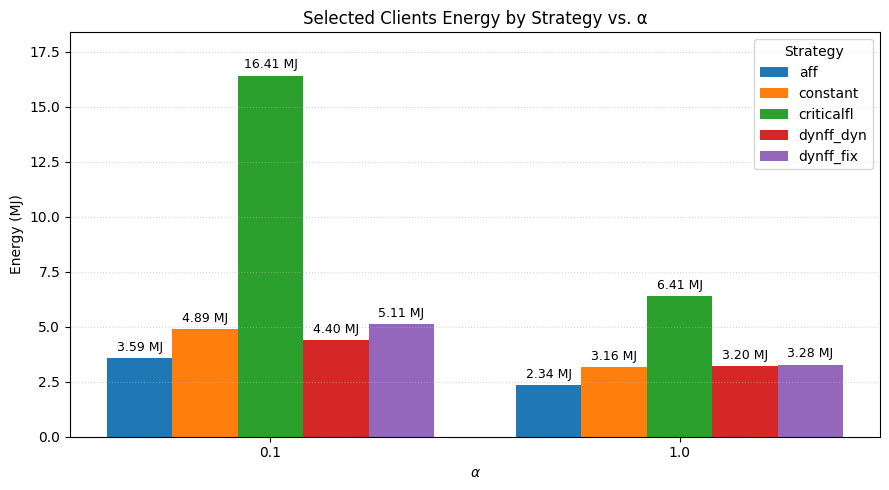

In [45]:
plot_energy_grouped_with_labels({
    'aff': selected_energy_aff,
    'constant': selected_energy_constant,
    'criticalfl': selected_energy_critical,
    # 'hetaaff': selected_energy_hetaaff,
    'dynff_dyn': selected_energy_dynff_dyn,
    'dynff_fix': selected_energy_dynff_fix,
}, x_order=[0.1, 1.0], title="Selected Clients Energy by Strategy vs. α")

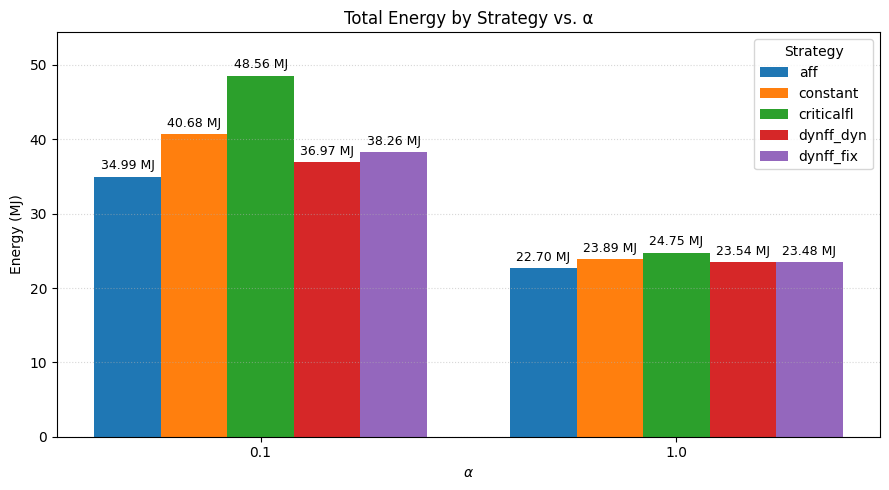

In [46]:
plot_energy_grouped_with_labels({
    'aff': totals_energy_aff,
    'constant': totals_energy_constant,
    'criticalfl': totals_energy_critical,
    # 'hetaaff': totals_energy_hetaaff,
    'dynff_dyn': totals_energy_dynff_dyn,
    'dynff_fix': totals_energy_dynff_fix,
}, x_order=[0.1, 1.0])

In [47]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

def plot_accuracy_by_strategy(
    data=None,
    *,
    prefix="df_acc_rounds_mean_",
    namespace=None,
    alphas=None,
    strategy_order=None,
    figsize=(12, 3),
    ylabel="Test Accuracy",
    xlabel="Rounds",
    legend_title="Strategy",
    zoom_last_n=10,                    # <-- novo: tamanho da janela do zoom
    inset_size=("42%", "26%"),         # <-- novo: (largura, altura) do inset
    inset_loc="lower right",          # <-- novo: posição do inset
    show_connectors=True               # <-- novo: desenhar conectores/retângulo
):
    df = _to_long_df(data, prefix=prefix, namespace=namespace)

    if alphas is None:
        alphas = sorted(df["alpha"].dropna().unique())

    if strategy_order is None:
        strategy_order = list(pd.unique(df["strategy"]))

    fig, axes = plt.subplots(1, len(alphas), figsize=figsize, sharey=True)
    if len(alphas) == 1:
        axes = [axes]

    handles, labels = [], []

    for ax, a in zip(axes, alphas):
        dfa = df[df["alpha"] == a].sort_values(["strategy", "round"])

        # Guardar as cores por estratégia para repetir no inset
        color_by_strat = {}

        for strat in strategy_order:
            d = dfa[dfa["strategy"] == strat]
            if d.empty:
                continue
            (h,) = ax.plot(d["round"], d["cen_accuracy"], linewidth=2, label=strat)
            color_by_strat[strat] = h.get_color()
            if strat not in labels:
                handles.append(h); labels.append(strat)

        ax.set_title(rf"$\alpha = {a}$")
        ax.set_xlabel(xlabel)
        ax.grid(True, linestyle=":", alpha=0.5)

        # ---------- inset (zoom nas últimas N rodadas) ----------
        if zoom_last_n:
            r_max = int(dfa["round"].max())
            r_min = int(dfa["round"].min())
            x0 = max(r_min, r_max - zoom_last_n)

            mask_last = dfa["round"].between(x0, r_max)
            y0 = float(dfa.loc[mask_last, "cen_accuracy"].min())
            y1 = float(dfa.loc[mask_last, "cen_accuracy"].max())
            pad = 0.05 * (y1 - y0 if y1 > y0 else 1.0)

            # inset menor e deslocado PARA CIMA (longe do eixo-x)
            axins = inset_axes(
                ax,
                width=inset_size[0], height=inset_size[1],
                loc=inset_loc,
                bbox_to_anchor=(0, 0.10, 1, 1),   # empurra ~10% para cima
                bbox_transform=ax.transAxes,
                borderpad=0.6
            )

            # replota com as mesmas cores
            for strat in strategy_order:
                d = dfa[dfa["strategy"] == strat]
                if d.empty: 
                    continue
                axins.plot(d["round"], d["cen_accuracy"], linewidth=1.3,
                           color=color_by_strat.get(strat))

            axins.set_xlim(x0, r_max)
            axins.set_ylim(y0 - pad, y1 + pad)

            # evita sobrepor rótulos do eixo-x principal
            # axins.tick_params(labelbottom=False, labelleft=False, length=0)
            axins.tick_params(axis="both", which="both",
                  labelbottom=True, labelleft=True,
                  labelsize=8, length=2, pad=1)

            axins.grid(True, linestyle=":", alpha=0.35)

            if show_connectors:
                ax.indicate_inset_zoom(axins, edgecolor="0.5", lw=1, alpha=0.7)
        # --------------------------------------------------------

    axes[0].set_ylabel(ylabel)

    if handles:
        fig.legend(handles, labels, loc="upper center",
                   ncol=len(labels), title=legend_title)
    fig.tight_layout(rect=[0, 0, 1, 0.88])
    plt.show()


/tmp/ipykernel_111215/3397086823.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.88])


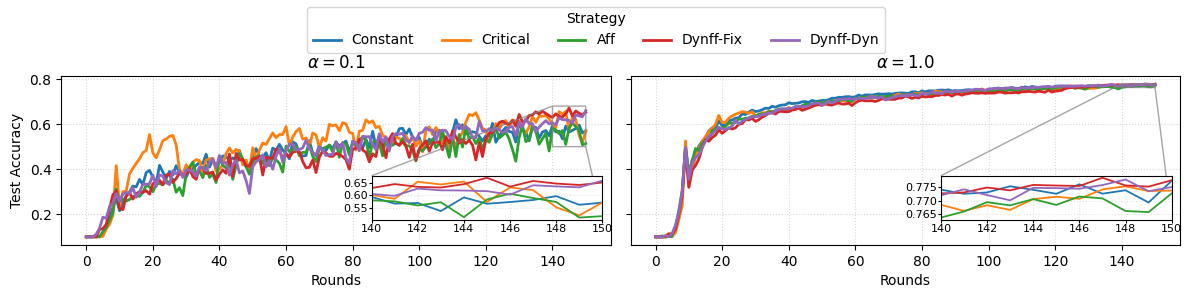

In [48]:
plot_accuracy_by_strategy({
    "Constant":  df_acc_rounds_mean_constant,
    "Critical":  df_acc_rounds_mean_critical,
    "Aff":       df_acc_rounds_mean_aff,
    # "Hetaaff":   df_acc_rounds_mean_hetaaff,
    "Dynff-Fix":     df_acc_rounds_mean_dynff_fix,
    "Dynff-Dyn":     df_acc_rounds_mean_dynff_dyn,
})